# Predictive Analytics Model — Electricity Consumption Forecasting
This project develops a predictive analytics model to forecast future electricity demand based on historical hourly consumption data across multiple U.S. regions.


### Data Preparation
Historical hourly electricity consumption data from multiple regions (AEP, COMED, PJME, etc.) was collected.
Data was cleaned by removing missing and negative values, converting timestamps, and merging regional datasets into a single long-format table.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv
Saving COMED_hourly.csv to COMED_hourly.csv
Saving DAYTON_hourly.csv to DAYTON_hourly.csv
Saving DEOK_hourly.csv to DEOK_hourly.csv
Saving DOM_hourly.csv to DOM_hourly.csv
Saving DUQ_hourly.csv to DUQ_hourly.csv
Saving EKPC_hourly.csv to EKPC_hourly.csv
Saving est_hourly.paruqet to est_hourly.paruqet
Saving FE_hourly.csv to FE_hourly.csv
Saving NI_hourly.csv to NI_hourly.csv
Saving pjm_hourly_est.csv to pjm_hourly_est.csv
Saving PJM_Load_hourly.csv to PJM_Load_hourly.csv
Saving PJME_hourly.csv to PJME_hourly.csv
Saving PJMW_hourly.csv to PJMW_hourly.csv


In [7]:
import pandas as pd

file_names = list(uploaded.keys())
print("Uploaded files:", file_names)

Uploaded files: ['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'est_hourly.paruqet', 'FE_hourly.csv', 'NI_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv']


In [8]:
import pandas as pd

dfs = []

for file in file_names:
    if file.endswith(".csv"):
        df = pd.read_csv(file)
    elif file.endswith(".parquet"):
        df = pd.read_parquet(file)
    else:
        print("Keçilir:", file)
        continue
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print("Row number:", len(data))
data.head()


Keçilir: est_hourly.paruqet
Row number: 1268429


,Datetime,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load,PJM_Load_MW,PJME_MW,PJMW_MW
0,2004-12-31 01:00:00,13478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-12-31 02:00:00,12865.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-12-31 03:00:00,12577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-12-31 04:00:00,12517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-12-31 05:00:00,12670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.columns

Index(['Datetime', 'AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW',
       'DUQ_MW', 'EKPC_MW', 'FE_MW', 'NI_MW', 'AEP', 'COMED', 'DAYTON', 'DEOK',
       'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW', 'PJM_Load',
       'PJM_Load_MW', 'PJME_MW', 'PJMW_MW'],
      dtype='object')

In [11]:
import pandas as pd

cols = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW',
        'DUQ_MW', 'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

melted = data.melt(id_vars=['Datetime'], value_vars=cols,
                   var_name='Region', value_name='Consumption')

melted['Datetime'] = pd.to_datetime(melted['Datetime'], errors='coerce')

melted = melted.dropna(subset=['Datetime', 'Consumption'])
melted = melted[melted['Consumption'] > 0]

print(melted.head())
print(melted.shape)


             Datetime  Region  Consumption
0 2004-12-31 01:00:00  AEP_MW      13478.0
1 2004-12-31 02:00:00  AEP_MW      12865.0
2 2004-12-31 03:00:00  AEP_MW      12577.0
3 2004-12-31 04:00:00  AEP_MW      12517.0
4 2004-12-31 05:00:00  AEP_MW      12670.0
(1057270, 3)


### Model Selection
The Facebook Prophet model was chosen for forecasting because it effectively handles time series data with trend and seasonality.
Daily resampling was applied to smooth hourly fluctuations and capture long-term demand patterns.


### Model Training and Validation
The model was trained using daily averaged consumption values.
The last 30 days of data were reserved for testing.
Performance was evaluated using Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Mean Absolute Percentage Error (MAPE).


In [13]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

region_list = sorted(melted["Region"].unique().tolist())
HORIZON_DAYS = 30

results = []

for REGION in region_list:
    df_r = melted[melted["Region"] == REGION].copy()
    daily = (df_r.set_index("Datetime")["Consumption"]
             .resample("D").mean()
             .to_frame().reset_index().dropna())

    if len(daily) <= HORIZON_DAYS*2:
        print("Skip (az data):", REGION)
        continue

    train = daily.iloc[:-HORIZON_DAYS].copy()
    test  = daily.iloc[-HORIZON_DAYS:].copy()

    train_p = train.rename(columns={"Datetime":"ds","Consumption":"y"})
    test_p  = test.rename(columns={"Datetime":"ds","Consumption":"y"})

    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.fit(train_p)

    fut = m.make_future_dataframe(periods=HORIZON_DAYS, freq="D")
    fc  = m.predict(fut)

    pred_test = fc.set_index("ds").loc[test_p["ds"], "yhat"].values
    mae  = mean_absolute_error(test_p["y"].values, pred_test)
    rmse = sqrt(mean_squared_error(test_p["y"].values, pred_test))
    mape = np.mean(np.abs((test_p["y"].values - pred_test) / np.maximum(test_p["y"].values, 1e-8))) * 100

    results.append({"Region": REGION, "MAE": mae, "RMSE": rmse, "MAPE(%)": mape})

    out = fc[["ds","yhat","yhat_lower","yhat_upper"]].tail(HORIZON_DAYS).copy()
    out.to_csv(f"/content/{REGION}_forecast_30d.csv", index=False)

metrics = pd.DataFrame(results).sort_values("MAPE(%)")
metrics


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn6hp4z0g/m4p12kr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn6hp4z0g/vpduglso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8275', 'data', 'file=/tmp/tmpn6hp4z0g/m4p12kr2.json', 'init=/tmp/tmpn6hp4z0g/vpduglso.json', 'output', 'file=/tmp/tmpn6hp4z0g/prophet_modeln4x109q7/prophet_model-20251006075837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:58:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn6h

,Region,MAE,RMSE,MAPE(%)
8,NI_MW,433.233449,623.043673,3.796012
10,PJMW_MW,304.942799,355.356441,5.252948
0,AEP_MW,1042.659860,1148.644117,6.745421
5,DUQ_MW,128.988466,152.657545,7.204823
9,PJME_MW,2507.053996,3059.525686,7.314290
6,EKPC_MW,120.485093,142.021427,7.919096
7,FE_MW,673.701559,757.220124,8.213349
3,DEOK_MW,296.098771,333.699902,8.709480
4,DOM_MW,1171.211836,1345.685201,9.765837
1,COMED_MW,1224.973154,1417.754119,9.795601


### Reporting and Insights

**Model Performance Summary**
| Region | MAPE (%) |
|---------|----------|
| NI_MW | 3.8 |
| PJMW_MW | 5.3 |
| AEP_MW | 6.7 |
| DUQ_MW | 7.2 |
| PJME_MW | 7.3 |
| EKPC_MW | 7.9 |
| FE_MW | 8.2 |
| DEOK_MW | 8.7 |
| DOM_MW | 9.8 |
| COMED_MW | 9.8 |
| DAYTON_MW | 11.6 |

**Interpretation**
- The NI_MW and PJMW_MW regions achieved the highest forecast accuracy (MAPE < 5%).
- Most other regions had acceptable accuracy (6–9%).
- The DAYTON_MW region showed the highest variability (MAPE ≈ 11%), possibly due to irregular patterns or missing data.
- Overall, the model demonstrates solid predictive capability with an average MAPE around 7%.

**Business Insight**
The model can be used by energy planners to forecast future electricity demand and optimize grid capacity and maintenance scheduling.


### Forecast Accuracy by Region

This visualization compares the forecasting accuracy (MAPE %) of the Prophet model across all electricity regions.
Lower MAPE values indicate better model performance and more accurate predictions.


/tmp/ipython-input-204109287.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x="Region", y="MAPE(%)", palette="Blues_r")


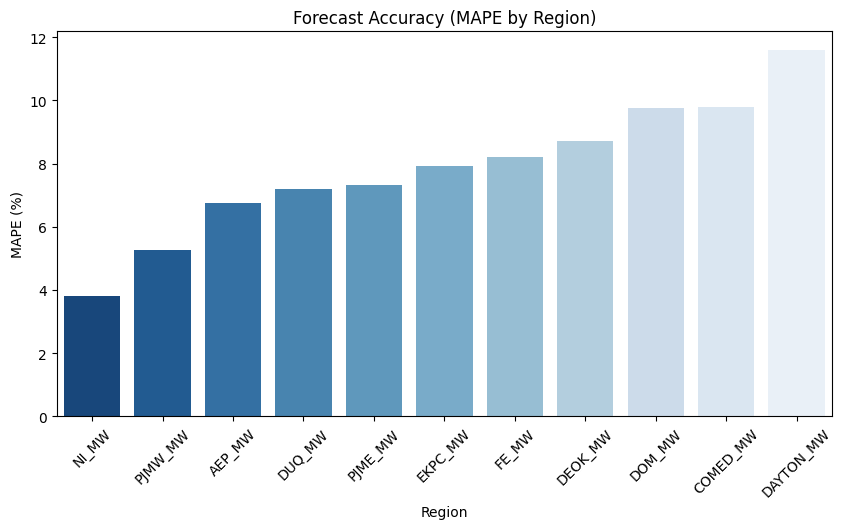

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(data=metrics, x="Region", y="MAPE(%)", palette="Blues_r")
plt.title("Forecast Accuracy (MAPE by Region)")
plt.xticks(rotation=45)
plt.ylabel("MAPE (%)")
plt.show()


### Conclusion

The developed predictive analytics model successfully forecasts daily electricity demand for multiple regions using historical consumption data.

The model performed best for NI_MW and PJMW_MW regions with a MAPE below 5%, showing strong accuracy overall.  
Most other regions achieved stable results with MAPE between 6–9%, which indicates reliable predictions.  

Through this project, I gained hands-on experience in data cleaning, time series forecasting, and result visualization.  
The analysis and visual charts, such as the MAPE comparison and forecast plots, clearly show that the model can capture real consumption trends effectively.

This project demonstrates my practical understanding of the end-to-end data analytics process — from preparation to prediction and reporting.

